In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

In [4]:
def evaluate(y_true, y_prob, titulo="Model"):
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{titulo}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], '--')
    plt.title(f"ROC Curve - {titulo}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [5]:
df = pd.read_csv("treated_data.csv")
df = df.drop(columns=['Unnamed: 0'])

y = df['isFraud']
X = df.drop(columns=['isFraud', 'types'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

[LightGBM] [Info] Number of positive: 5738, number of negative: 4447715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 4453453, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001288 -> initscore=-6.653035
[LightGBM] [Info] Start training from score -6.653035

LightGBM - Basic
Accuracy:  0.9976
Precision:  0.1954
Recall:    0.2773
AUC-ROC:   0.6670


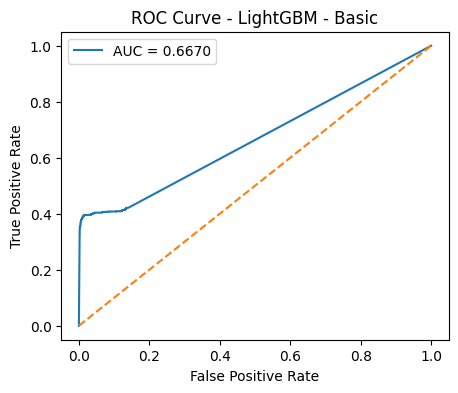

In [ ]:
lgb_basic = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_basic.fit(X_train, y_train)

y_prob_lgb = lgb_basic.predict_proba(X_test)[:, 1]

evaluate(y_test, y_prob_lgb, "LightGBM - Basic")

[LightGBM] [Info] Number of positive: 5738, number of negative: 28690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 34428, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166667 -> initscore=-1.609438
[LightGBM] [Info] Start training from score -1.609438

LightGBM - Undersampling (Treino Balanceado, Teste Real)
Accuracy:  0.9969
Precision:  0.2900
Recall:    0.9947
AUC-ROC:   0.9996


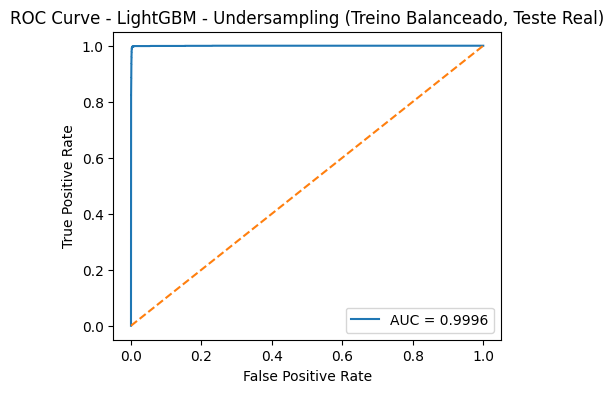

In [ ]:
train_df = X_train.copy()
train_df['isFraud'] = y_train

df0 = train_df[train_df['isFraud'] == 0]
df1 = train_df[train_df['isFraud'] == 1]  

ratio = 5

n_samples_0 = min(len(df0), len(df1) * ratio)

df0_under = resample(
    df0,
    replace=False,
    n_samples=n_samples_0,
    random_state=42
)

train_bal = pd.concat([df0_under, df1])

X_train_bal = train_bal.drop(columns=['isFraud'])
y_train_bal = train_bal['isFraud']

lgb_under = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_under.fit(X_train_bal, y_train_bal)

y_prob_under = lgb_under.predict_proba(X_test)[:, 1]

# 7) Avaliar
evaluate(y_test, y_prob_under, "LightGBM - Undersampling (Treino Balanceado, Teste Real)")

Class weights: {0: np.float64(0.5006450503235931), 1: np.float64(388.0666608574416)}
[LightGBM] [Info] Number of positive: 5738, number of negative: 4447715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 4453453, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LightGBM - Class Weight
Accuracy:  0.9972
Precision:  0.3151
Recall:    0.9955
AUC-ROC:   0.9996


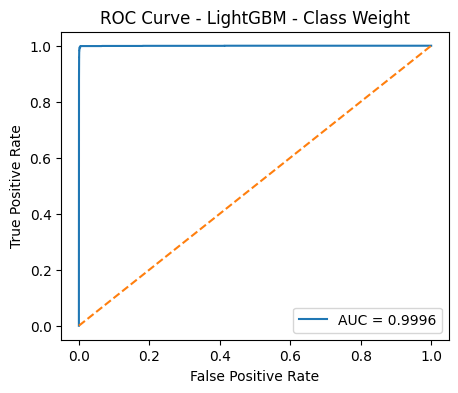

In [ ]:
classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
cw = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", cw)

lgb_weight = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight=cw,
    n_jobs=-1
)

lgb_weight.fit(X_train, y_train)

y_prob_weight = lgb_weight.predict_proba(X_test)[:, 1]

evaluate(y_test, y_prob_weight, "LightGBM - Class Weight")